![McLaren Maze Race Banner](media/banner.png)

# Welcome to Young Driver - level 2 of the McLaren Maze Race!

In this level, things take a serious step up from the Learner Driver level. Firstly the mazes are a lot larger and more complex than those you have encoutnered so far. In particular, they contain choices of direction at certain turns; one direction is correct and one leads to a dead end. Let's take a look at one:

In [1]:
%matplotlib ipympl
from imports import * 

track = TrackStore.load_track(level=Level.Young, index=1)  # provide the level and, optionally, an index. If no index
                                                             # is provided a random track will be loaded.
track.plot_track();                      # a useful method to display the track

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We can see that some of the turns have only one way to go but several of them have two. A simple starting strategy would be to just choose a direction randomly. If we get it wrong then the driver will need to learn to brake to a halt then turn around and head back in the other direction. To build a true race-winning AI, however, we will need to figure out a way of choosing the right direction - more on this later!

### Safety Car
Now let's consider the second challenge of level 2: safety cars. No driver is allowed out on track without understanding the rules of the safety car. In our Maze Race, the rules are as follows:
- A safety car can be deployed by Race Control at any point
- Drivers will be notified that a safety car is active via the `TrackState.safety_car_active` variable passed to the `Driver.make_a_move` method
- When the safety car is active no driver may exceed the safety car speed
- Any driver who does exceed this speed will be given a penalty that increases in severity each turn the driver breaks the speed limit
- The safety car will be withdrawn after a certain number of moves
- Feedback on whether the current car speed is acceptable will be given to the driver via the `ActionResult.safety_car_speed_exceeded` field passed to the driver after each move
- Critically, **the driver is not told what the safety car speed is!** The AI must work out what this is by itself.
- Furthermore, **the safety car speed will be different each time it is deployed**. Driver's which can quickly figure out the right speed to drive at will gain a benefit- The current penalty level a driver is at is reported to the driver in the `ActionResult.safety_car_penalty_level` field. A wise driver will adapt their behaviour depending on the current penalty level.

The safety car rules need to be taken seriously. The penalties will quickly build up and ruin our driver's chances if our AI doesn't adapt to the deployment of a safety car. A simple way of handling the safety car would be to add the deployment status to our state vector, i.e.,
<p style="text-align: center;"> state = [rounded speed, distance ahead, safety car deployed]</p>

However, this has some big downsides. Firstly, it increases the size of the state space: the Q table will now have 3 dimensions and the driver has to learn what to do in every state with and without the safety car deployed. Secondly, as the safety car speed changes each time it is deployed our Q table would be incorrect for a new safety car and we would need to learn everything again. This won't give us the rapid adaptation that we need.

Instead, let's introduce a single new variable that our AI needs to learn: `safety_car_speed`. Then in `make_a_move`, if the safety car is deployed and we are going above this speed, we know we need to brake. 

    def make_a_move(self, car_state: CarState, track_state: TrackState):
        if track_state.safety_car_active:
            if car_state.speed > self.safety_car_speed:     # safety car active and we are above speed
                return Action.LightBrake                    # ignore everything else and LightBrake

        # Safety car not active, or we are under the speed already - use Q table to determine action
        return super().make_a_move(car_state, track_state)

But how can we learn what the speed is? Well the simplest approach is to start with it set to an arbitrary value, then, if we receive a safety car penalty we can decrease the learnt `safety_car_speed` to the speed we were travelling when we were penalised. Conversely, if we didn't receive any penalty then we know that this is a safe speed.

    if previous_track_state.safety_car_active:
        if result.safety_car_speed_exceeded:  # we ended up going too fast so safe speed must be below current speed
            self.safety_car_speed = min(self.safety_car_speed, new_car_state.speed - 1)
        else:                                 # our current speed is safe so safe speed must be higher
            self.safety_car_speed = max(self.safety_car_speed, new_car_state.speed + 1)

This approach can definitely be improved though. For example, if we are currently under the safe speed then we ignore the safety car and take an action as normal, an action that could easily push us back over the speed limit. It also doesn't allow the AI to choose whether to apply heavy or light braking, something that can make a big difference depending on the driver's current speed. This approach doesn't take the penalty level into account. Whilst the penalty is low, it might be worthwhile for the driver to try and push the speed higher to try and find the limit whereas if the penalty level is high it would probably be better for the driver to play it safe and decrease speed significantly. It is up to you to take up this challenge and build a better AI!

For now, let's try it out by making use of the `safety_car_sim`. This trains the driver on a simple straight and then turns the safety car on to see how the driver reacts.

In [2]:
from drivers.youngdriver import YoungDriver

driver_name = 'Laniel'
set_seed(0)
car = Car.get_car_for_level(Level.Young)    # do this explicitly now for random seed control

In [3]:
driver = YoungDriver(driver_name, random_action_probability=1, random_action_decay=0.99, max_distance=1, batch_learn=False)

# Run the safety car sim
set_seed(0)
car_speed, safety_car_estimate, safety_car_true, safety_car_penalty = safety_car_sim(driver, level=Level.Young)

Running safety car sim...
Safety car deployed for 50 turns at 100 speed
	Decreasing estimate of safety car speed to  109.0
	Car speed of 118.97572783105288 above current safety car estimate of 108.97572783105288 so applying the brakes.
	Decreasing estimate of safety car speed to  96.6
	Car speed of 106.64583009627147 above current safety car estimate of 96.64583009627147 so applying the brakes.
Safety car speed estimate of  96.6 already below car speed of  125.7
	Car speed of 125.73448547481658 above current safety car estimate of 96.64583009627147 so applying the brakes.
Safety car speed estimate of  96.6 already below car speed of  112.7
	Car speed of 112.7041525161371 above current safety car estimate of 96.64583009627147 so applying the brakes.
	Decreasing estimate of safety car speed to  91.0
	Car speed of 101.02420148627266 above current safety car estimate of 91.02420148627266 so applying the brakes.
	Increasing estimate of safety car speed to  91.6
Safety car speed estimate of 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Complete


We can see that the driver is able to estimate the safety car speed to a reasonable accuracy quite quickly. The AI will slow the car down if it is travelling faster than the estimated safety car speed, however, as soon as the driver is below the required speed it accelerates again and so keeps incurring a penalty. To improve this we need some way of predicting whether we are going to break the speed cap next turn if we apply an action - we will introduce this at the next level. For the moment, we could add a margin to the safety car limit and prevent the driver from acelerating within this; or perhaps you can think of something better? We leave this in your hands!

### Learning to navigate
Now we have some sort of strategy in place for the safety car, let's return to the problem of figuring out which way to turn at a branch point. Making a wrong turn and ending up in a dead end isn't a race ending mistake because, once we have turned around, we will be facing the right direction and will be swiftly back on track. Still, the time lost taking a dead end route might cost you victory.

Our problem is that the state doesn't give us enough information to work out which is the correct direction - we only get the length of the straight to the left and the right. If we are to be able to do better than random guessing there needs to be some structure in the distribution of correct turn directions that we can learn and exploit. A common approach in this situation is to create some exploratory plots to see if we can find any relationshio that we can use. 

In [4]:
left_turn_positions = []
right_turn_positions = []
for track in TrackStore.load_all_tracks(level=Level.Young):
    for position, turn_action in track.correct_turns.items():
        if Action.TurnLeft == turn_action:
            left_turn_positions.append((position.row, position.column))
        else:
            right_turn_positions.append((position.row, position.column))
left_turn_positions = np.array(left_turn_positions)
right_turn_positions = np.array(right_turn_positions)
            
fig = plt.figure()
plt.plot(left_turn_positions[:, 1], left_turn_positions[:, 0], 'r+')
plt.plot(right_turn_positions[:, 1], right_turn_positions[:, 0], 'g+')
plt.legend(['Left turns', 'Right turns'], fontsize=14);
fig.gca().invert_yaxis()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We can see that the correct direction to turn is stongly clustered across all the tracks - the turns in one area of the maze are always in the the same direction. We can't guarantee that the exact mapping from position to turn direction will be the same at different levels and in the Challenge (hint - it won't) so we need our AI driver to be able to learn and adapt as it sees where the correct turns are. The easiest way of implementing this is to use a *nearest neighbour* model. For this, we need to record the position of each correct turn. Helpfully, after each race our driver is given the positions of all the correct turns to learn from, so we can implement our learning like this,

    def update_after_race(self, correct_turns: Dict[Position, Action]):
        # Called after the race by RaceControl
        self.correct_turns.update(correct_turns)            # dictionary mapping Position -> TurnLeft or TurnRight


Then when we have to make a decision we will look for the closest turn we have previously recorded and choose the same action as that:

    def _choose_turn_direction(self, track_state: TrackState):
        # Check if we need to make a decision about which way to turn
        if track_state.distance_left > 0 and track_state.distance_right > 0:  # both options available, need to decide
            if len(self.correct_turns) > 0:
                # Find the closest turn we have seen previously and turn in the same direction
                distances = np.array([track_state.position.distance_to(turn_position)
                                      for turn_position in self.correct_turns])           # Euclidean distance
                i_closest = np.argmin(distances)
                return list(self.correct_turns.values())[i_closest]
            else:  # First race, no data yet so choose randomly
                return np.random.choice([Action.TurnLeft, Action.TurnRight])

Let's test this out by running our driver over a number of tracks to populate our correct turns list, and then watching the driver over a final track.

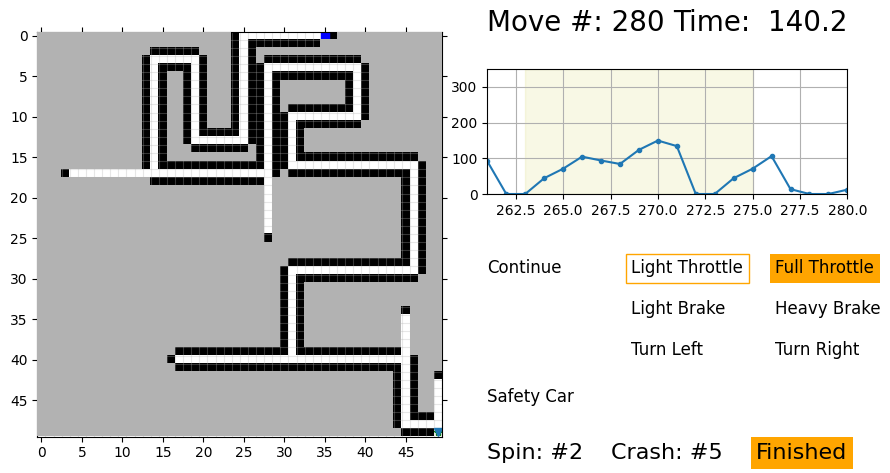

Safety car deployed for 12 turns at 100 speed
	Car speed of  144.0 exceeds safety car, penalty is now 1
	Decreasing estimate of safety car speed to  134.0
	Car speed of 144.00249415430264 above current safety car estimate of 134.00249415430264 so applying the brakes.
	Car speed of  129.1 exceeds safety car, penalty is now 2
	Decreasing estimate of safety car speed to  119.1
	Car speed of 129.078979427019 above current safety car estimate of 119.078979427019 so applying the brakes.
	Car speed of  115.7 exceeds safety car, penalty is now 3
	Decreasing estimate of safety car speed to  105.7
	Car speed of 115.70204410534487 above current safety car estimate of 105.70204410534487 so applying the brakes.
	Car speed of  103.7 exceeds safety car, penalty is now 4
	Decreasing estimate of safety car speed to  93.7
	Car speed of 103.71141040609275 above current safety car estimate of 93.71141040609275 so applying the brakes.
	Increasing estimate of safety car speed to  94.0
	Car speed of  115.3 e

In [5]:
driver = YoungDriver(driver_name)
season = Season(Level.Young)
set_seed(1)
driver, *_ = season.race(driver=driver, track_indices=range(23))          # run over several tracks to train
set_seed(1)
driver, *_ = season.race(driver=driver, track_indices=[23], plot=True)    # watch the next track
print('Race completed')
plt.close()

Alright, our AI made the right turn almost every time. If you check the places where the AI made a wrong turn against the scatter plot above you will usually see that they lie near the boundary between a left and right turn region. As we don't know the exact boundaries of the regions (which might be more complex in the online Challenge) and the driver will start off knowing nothing, there is always a possibility that the AI will make a wrong turn. This means that we need to be able to handle going down a dead end branch. We do have a way of measuring our confidence in a particular turn though - if a branch is very close in position to a branch we have seen before we can be pretty confident of the correct direction. However, if the the branch position is far away from all other points, or if it is close to both turn left and turn right points, then it is more likely that our choice will be wrong. We leave it up to you to find a way to use this if you want to!

## State Space
It looks like our driver is still crashing even after racing on a number of different tracks. This suggests that our AI hasn't converged to a good solution yet and is still learning. Preventing the car from crashing is the first thing that the driver learns because crashing has such a high penalty. If the driver does crash it usually means that the driver has come across a state that it has rarely visited before and so it hasn't learnt how to avoid crashing. This suggests that the AI might not have explored the state space very well - there might be a lot of states where the AI has very little experience. We can investigate this by looking at the `state_counts` variable in our driver class, which records the number of times the AI has visited each state. Let's first check how many states our driver has visited relative to the total number of states in the space. Recall that our state is made up of two variables: the (rounded) car speed and the distance ahead of the car to the end of the straight. With speed rounding set to 10 and a max speed of 300, there are 31 different values that speed can take in our state. The total state space size is thus 31 times the longest straight that our driver has come across:

In [6]:
max_num_states = 31 * max(state[1] for state in driver.state_counts.keys())
num_visited = len(driver.state_counts)
print(f'Total state space has {max_num_states} states in it.')
print(f'Driver has visited {num_visited} states, {num_visited / max_num_states * 100:.1f}%')

Total state space has 1488 states in it.
Driver has visited 333 states, 22.4%


It looks like the majority of the state space hasn't been visited at all. We can check the number of times each of states that the AI has been to have been visited:

In [7]:
n, e = np.histogram(list(driver.state_counts.values()), [0, 10, 50, 100, 200, 300])
fig = plt.figure()
x = np.arange(len(n))
plt.bar(x, n / np.sum(n) * 100)
fig.gca().set_xticks(x)
fig.gca().set_xticklabels(['1-10', '10-50', '50-100', '100-200', '200+'])
plt.ylabel('Percentage of visited states', fontsize=16);
plt.xlabel('Number of times visited state', fontsize=16);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The histogram suggests that most of the states that are visited are visited less than 10 times. So on top of only exploring a few states of the states that the AI does visit it spends the majority of time in just a handful of states. Now, this might not be a problem if the AI has correctly identifed these states as being the only important ones but given our driver still experiences the occaisional crash we suspect that it is missing some important states. 

Ideally we would keep racing on more tracks but the season only has 24 tracks in it. This means we need to improve our AI's learning efficiency so that it can improve quicker. One way to improve state space coverage is with a better exploration algorithm. For example, rather than just randomly choosing an action from time-to-time, we could boost the chance of choosing actions that we have never (or rarely) tried in a particular state. Another step that might help is to reduce the number of states. We can reduce the state space size by increasing the level of rounding on the car speed and by saturating the distance ahead. Increasing the car rounding means our AI can't apply some finer speed control but that might be outweighed by better learning. The distance ahead of the car probably only matters when the driver is getting close to the end of the straight. When there is still enough space ahead of the driver to enable the AI to brake for the corner then it can just ignore the actual distance. This means we could reduce the state space by collapsing all distances above a certain value to this max distance.

### Learning Rate
If we reduce the state space like this then we need to consider the *learning rate* parameter. The learning rate controls how we combine new knowledge with the knowledge we have already accrued. Up to now we have been using a learning rate of 1, which means that, for each state, we throw away any Q value that we have previously learnt and replace it with the newly calculated value. This is the right strategy to take if the true Q value of a state is fixed, in which case the new value is the best estimate of the true Q value. However, if we have a large amount of speed rounding then it is likely the maximum safe cornering speed will fall somewhere in the middle of the speed range in a single state. This means that the same state and action can lead to different rewards. 

![Conflicting rewards](media\conflicting_rewards.png)

If the learning rate is set to 1 then the AI will only really remember whatever happened the last time it was in the state. This can lead to the driver oscillating controls: "the state is fine", "the state is too fast", "the state is fine", etc. We want our driver to remember that the state can lead to a crash even if it didn't happen the last time. This can be done with the learning rate. 

<p style="text-align: center;">Q value   =   learning rate  *  new Q value  +  ( 1 - learning rate )  *  old Q value </p>

For example, if the learning rate is set to 0.5 the new Q value for a state and action pair will be set to a 50/50 combination of the old value and the new value. Thus, a small learning rate value gives the AI a long 'memory' but makes it slow to adapt to new situations, whereas a learning rate close to 1 means the AI adapts very quickly by forgetting previous rewards.

Let's create a driver with a higher speed rounding, distance saturation, and a lower learning rate and test it out:

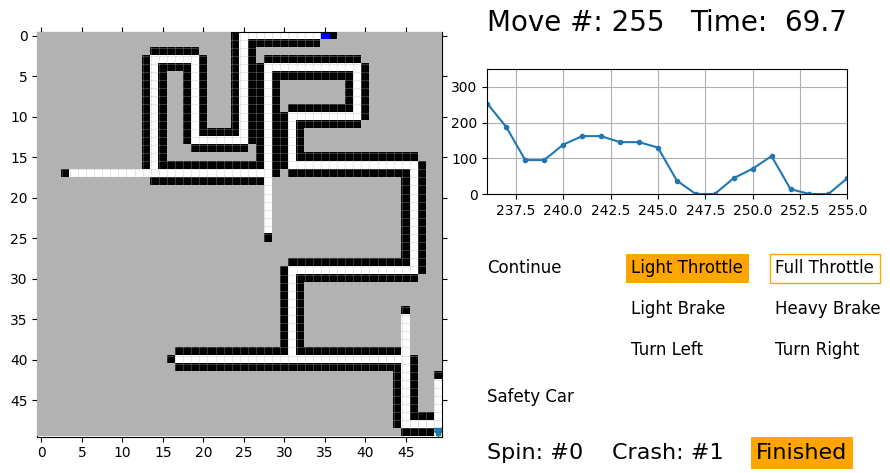

Safety car deployed for 12 turns at 100 speed
	Car speed of 237.03175374777135 above current safety car estimate of 100.85493858083538 so applying the brakes.
	Car speed of  212.5 exceeds safety car, penalty is now 1
Safety car speed estimate of  100.9 already below car speed of  212.5
	Car speed of 212.46727041251484 above current safety car estimate of 100.85493858083538 so applying the brakes.
	Car speed of  190.4 exceeds safety car, penalty is now 2
Safety car speed estimate of  100.9 already below car speed of  190.4
	Car speed of 190.44849596219615 above current safety car estimate of 100.85493858083538 so applying the brakes.
	Car speed of  170.7 exceeds safety car, penalty is now 3
Safety car speed estimate of  100.9 already below car speed of  170.7
	Car speed of 170.71160910497684 above current safety car estimate of 100.85493858083538 so applying the brakes.
	Car speed of  153.0 exceeds safety car, penalty is now 4
Safety car speed estimate of  100.9 already below car speed 

In [8]:
driver = YoungDriver(driver_name, speed_rounding=40, max_distance=8, learning_rate=0.25)

season = Season(Level.Young)
set_seed(1)
driver, *_ = season.race(driver=driver, track_indices=range(23))          # run over several tracks to train
set_seed(1)
driver, *_ = season.race(driver=driver, track_indices=[23], plot=True)    # watch the next track
plt.close()    # cell keeps running for a while otherwise

That seems to have improved performance and reduced crashes. But is it overall faster? One way of testing this is to put the drivers head-to-head in a championship, similar to how the online challenge will be run. The drivers race the same mazes at the same time (with the same safety cars, etc). At the end of each race the drivers are cassified according to their race times, with the fastest race time winning and being assigned position 1. At the end of the season's races the drivers' positions are added up and the driver with the smallest total score (i.e. best average finishing position) is the champion.

Of course, our drivers are affected by random choices so to perform a thorough comparison we need to run the championship several times. We can do this like so (this will take a couple of minutes to run):

<IPython.core.display.Javascript object>


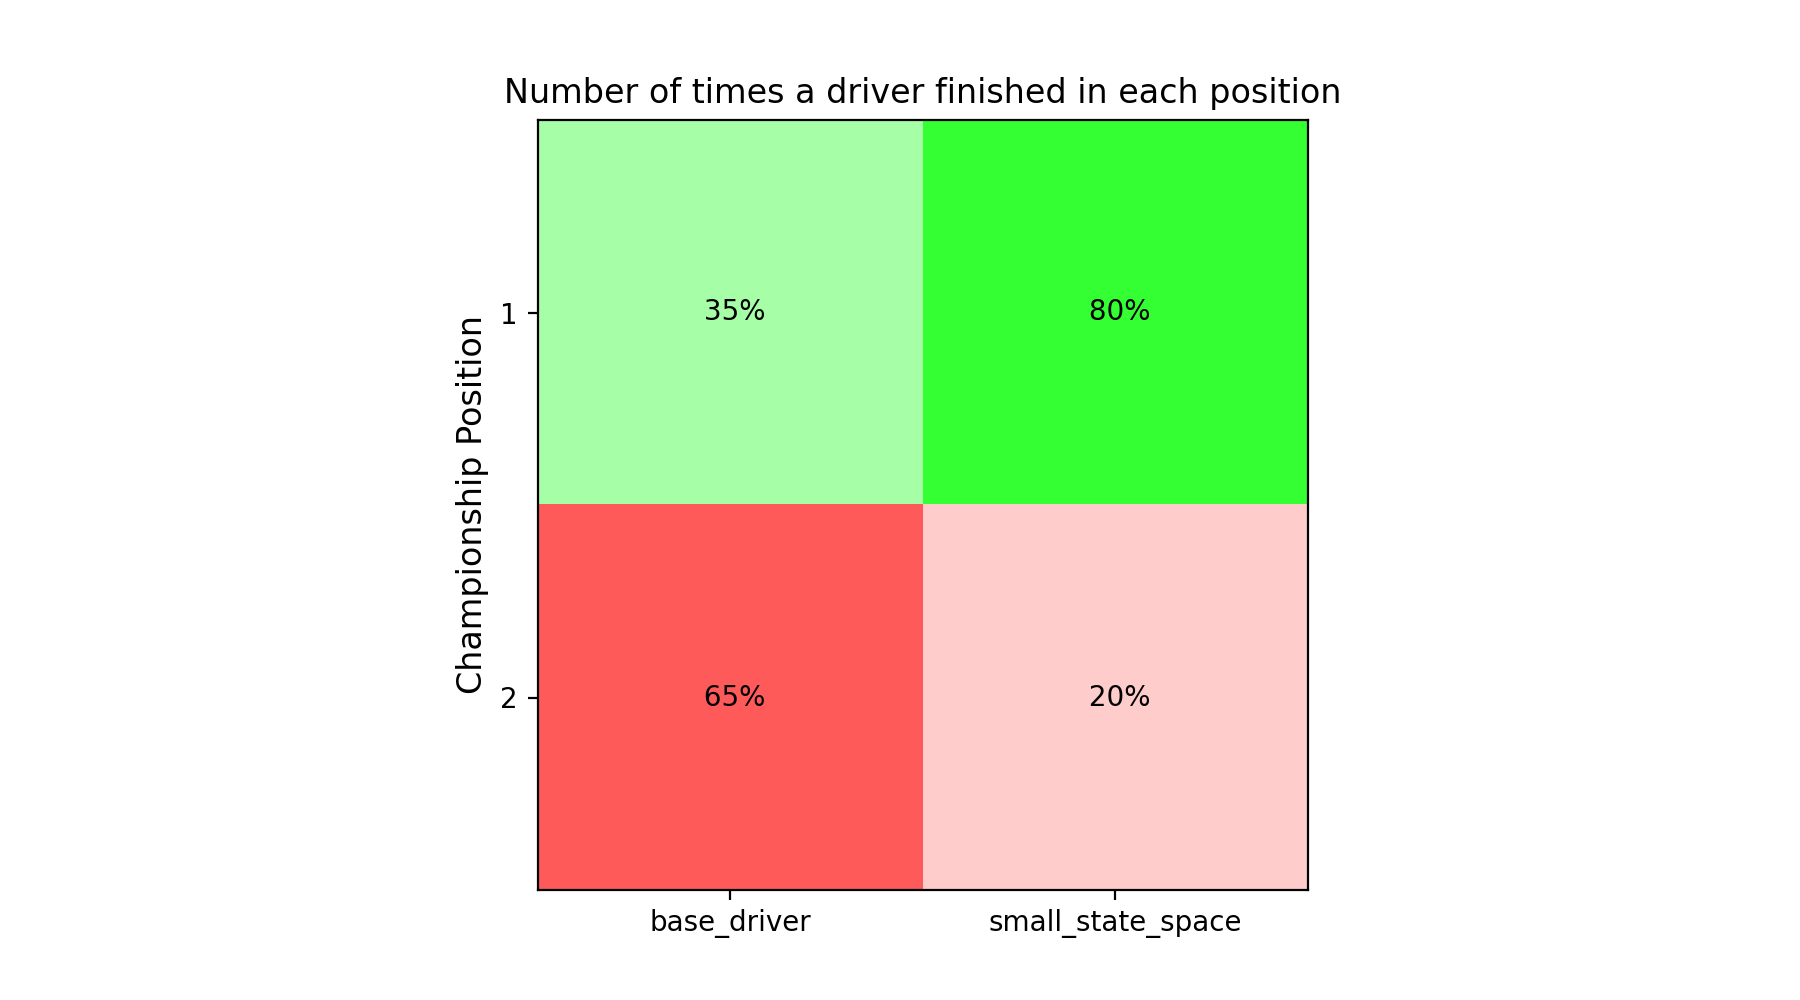

In [38]:
drivers = [
    YoungDriver('base_driver'),
    YoungDriver('small_state_space', speed_rounding=40, max_distance=8, learning_rate=0.25)
    ]

num_repeats = 20
championship = Championship(drivers, Level.Young)
championship_results, race_results, race_times = championship.run_championship(num_repeats=num_repeats)

# Plot the results as a coloured heatmap. 
# > colour represents championship position
# > transparency indicates the percentage of times a driver scored a particular position
# > dark green squares are best!
# > sums across rows can > 100% due to seasons ending as draws
plot_multiple_championship_results(championship_results)

It looks like the driver with the reduced state space wins more often (note, the percentages are normalised for each driver). You might like to extend the driver list to test out various parameterisations and see if you can improve the driver AI even more!

# We hope to see you in Level 3: Rookie Driver
This is the end of the Young Driver level. In the next level, Rookie Driver, we will introduce a completely different reinforecement learning algorithm based on a model that will give us a step forward in performance. We also add in DRS! We hope to see you there.

# Playground
If you want to play around with the driver class in this notebook, this class might be helpful.

In [ ]:
class MyYoungDriver(YoungDriver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def make_a_move(self, car_state: CarState, track_state: TrackState):
        return super().make_a_move(car_state, track_state)
        
    def _choose_randomly(self, available_actions: List[Action]):
        super()._choose_randomly(available_actions)
    
    def update_with_action_results(self, previous_car_state: CarState, previous_track_state: TrackState,
                                   action: Action, new_car_state: CarState, new_track_state: TrackState,
                                   result: ActionResult):
        super().update_with_action_results(previous_car_state, previous_track_state, 
                                           action, new_car_state, new_track_state, result)
    
    def _update_safety_car(self, new_car_state: CarState, result: ActionResult):
        super()._update_safety_car(new_car_state, result)

my_driver = MyYoungDriver(driver_name)

In [ ]:
race(driver=my_driver, level=Level.Young)
plt.close()

In [ ]:
plot_q_table(driver)